### Settings and Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy as sp
import scipy.optimize as opt
import sympy as sym
import numba
import itertools

[ipython line magics](http://ipython.readthedocs.io/en/stable/interactive/magics.html#line-magics)

In [2]:
%precision 3
np.set_printoptions(precision=3)

### Prepare tests

In [3]:
ATOL = 1e-6  # alpha tolerance

def random_points(n, vmin=-1.0, vmax=+1.0):
    return np.hstack([np.ones([n,1]), rnd.random([n,2])*(vmax-vmin)+vmin])

def random_line():
    p = random_points(2)
    a = (p[1,2] - p[0,1]) / (p[1,1] - p[0,1])
    b = p[0,2] - a * p[0,1]
    return np.array([-b, -a, 1.])

def line_y(w, z):
    return np.sign(z @ w)

def random_wzy(N=100):
    while 1:
        w = random_line()
        z = random_points(N)
        y = line_y(w, z)
        if (y == 0).sum():
            continue
        if (y < 0).sum() > N/5 and (y > 0).sum() > N/5:
            return w, z, y

def err_frac(w):
    return np.mean(line_y(w, z_test) != y_test)

In [4]:
rnd.seed(123)

w_goal, z_goal, y_goal = random_wzy(N=10)
z_test = random_points(10**4)
y_test = line_y(w_goal, z_test)
x_goal, x_test = z_goal[:, 1:], z_test[:, 1:]
x_goal, y_goal

(array([[-0.413,  0.262],
        [-0.816, -0.133],
        [-0.138, -0.013],
        [-0.148, -0.375],
        [-0.147,  0.787],
        [ 0.888,  0.004],
        [ 0.248, -0.769],
        [-0.365, -0.17 ],
        [ 0.733, -0.499],
        [-0.034,  0.971]]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]))

## PLA

In [5]:
@numba.jit
def pla(z, y):
    w = np.zeros(3)
    while True:
        e = np.where(z @ w * y <= 0)[0]
        if not e.size:
            return w
        i = rnd.choice(e)
        w += y[i] * z[i]

In [6]:
w_pla = pla(z_goal, y_goal)
( y_goal,
  line_y(w_pla, z_goal),
  err_frac(w_pla) )

(array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 0.032)

## SKLEARN.SVC

Links:
* [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/svm.html#svc)

In [7]:
from sklearn import svm

svc = svm.SVC(C=1e6, kernel='linear', verbose=True)
svc.fit(x_goal, y_goal)
w_svc = np.c_[svc.intercept_, svc.coef_].squeeze()
print(svc)
w_svc

[LibSVM]SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)


array([ 1.451, -2.769,  2.296])

In [8]:
print(svc.n_support_, svc.support_, svc.support_vectors_, sep='\n')

[2 1]
[5 6 3]
[[ 0.888  0.004]
 [ 0.248 -0.769]
 [-0.148 -0.375]]


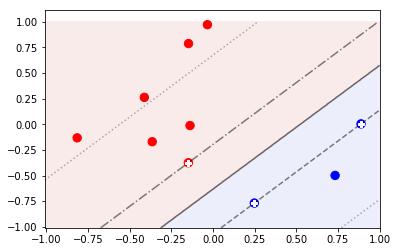

In [9]:
_x1, _x2 = np.meshgrid(np.arange(-1.01,1.01,.01), np.arange(-1.01,1.01,.01))
_y1 = svc.predict(np.c_[_x1.ravel(), _x2.ravel()]).reshape(_x1.shape)
plt.contourf(_x1, _x2, _y1, cmap=plt.cm.coolwarm, alpha=.1)
_y2 = svc.decision_function(np.vstack([_x1.ravel(), _x2.ravel()]).T).reshape(_x1.shape)
plt.contour(_x1, _x2, _y2, levels=[-1, 0, 1], alpha=.5, colors='k', linestyles=['--', '-', '-.'])
plt.contour(_x1, _x2, _y2, levels=[-3, 3], alpha=.3, colors='k', linestyles=[':', ':'])
plt.scatter(x_goal[:,0], x_goal[:,1], s=70, c=np.where(y_goal<0, ['b'], ['r']))
_sv = svc.support_vectors_
plt.plot(_sv[:,0], _sv[:,1], 'wP')

In [10]:
( y_goal,
  svc.predict(x_goal),
  svc.decision_function(x_goal).round(),
  (z_goal @ w_svc).round(),
  np.mean(svc.predict(x_test) != y_test),
  err_frac(w_svc) )

(array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 3.,  3.,  2.,  1.,  4., -1., -1.,  2., -2.,  4.]),
 array([ 3.,  3.,  2.,  1.,  4., -1., -1.,  2., -2.,  4.]),
 0.072,
 0.072)

## Quadratic problem

Primal SVM objective:
$$
  \min_w \frac12 \lVert w \rVert^2 \\
  \mbox{s.t.} \quad  y_i(w^Tx_i+b) \ge 1  \quad \forall i
$$
```
    m = x.shape[1]
    w_, b_ = Variable(m), Variable(1)
    objective = Minimize(0.5 * sum_squares(w_))
    constraints = [mul_elemwise(y, x @ w_ + b_) >= 1]
```

The corresponding dual problem:
$$
  \min_{\alpha} \frac12 \alpha^T K \alpha - 1^T \alpha \\
  \mbox{s.t.} \quad  \alpha_i \ge 0  \quad \forall i \\
  \mbox{and} \quad  y^T \alpha = 0
$$
```
    n = x.shape[0]
    yx = y[:,None] * x
    K = yx @ yx.T     # a.T*K*a == quad_form(a,K)
    a = Variable(n)   # alphas
    objective = Minimize(0.5 * quad_form(a, K) - sum_entries(a))
    constraints = [a >= 0, y.T @ a == 0]
```

## CVXPY

[CVXPY User Guide](http://www.cvxpy.org/en/latest/)

Advantages to `scipy.optimize`:

* `cvxpy` prooves, that the problem is convex
* convergence for convex optimization problems is guaranteed
  (might be also true for the above)
* in general: better accuracy
* in general: more robust in regards to numerical instabilities
  (solver is only able to solve SOCPs;
   not non-convex models like the SLSQP-approach above!)

Links:
* [stackoverflow: CVXPY error while solving SVM dual](https://stackoverflow.com/questions/33728518/cvxpy-error-cannot-multiply-two-non-constants-while-solving-svm-dual)
* [toy SVM problem implemented with CVXPY](https://www.cs.stanford.edu/~tachim/optimization_code.html)
* [build your own toy SVM with CVXPY](http://ecomunsing.com/build-your-own-support-vector-machine)
* [comparing CVXPY to python sci-kit learn yields different results](https://groups.google.com/forum/#!topic/cvxpy/m9Oe0Cj0Cgk)
* [CVXPY FAQ: What do I do if I get a DCPError exception?](http://www.cvxpy.org/en/latest/faq/#what-do-i-do-if-i-get-a-dcperror-exception)
* [SVM classifier with ℓ1-regularization](https://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/intro/SVM.ipynb)
* [CVXPY dual variables](http://www.cvxpy.org/en/latest/tutorial/advanced/#dual-variables)

In [11]:
import cvxpy

def svm_cvxpy_dual(x, y, atol=ATOL, verbose=False):
    from cvxpy import Variable, Problem, Minimize
    from cvxpy import sum_entries, quad_form

    n = len(x)
    yx = y[:,None] * x
    K = yx @ yx.T     # a.T*K*a == quad_form(a,K)
    a = Variable(n)   # alphas
    objective = Minimize(0.5 * quad_form(a, K) - sum_entries(a))
    constraints = [a >= 0, y.T @ a == 0]
    qp = Problem(objective, constraints)
    qp.solve(verbose=verbose)

    aval = np.array(a.value).squeeze(1)
    cond = np.abs(aval) > atol
    w_ = np.sum(x * (aval * y)[:,None], axis=0)
    b_ = (y - x @ w_)[cond]
    w = np.hstack((b_[0], w_))
    idx = list(cond.nonzero()[0])
    sv = x[idx]
    sv_y = sv @ w_ + b_

    return dict(status=qp.status, ok=(qp.status == 'optimal'),
                weights=w, alphas=aval[cond], atol=atol,
                n_sv=len(idx), sv_i=idx, sv=sv, sv_y=sv_y)

res_cxpd = svm_cvxpy_dual(x_goal, y_goal, verbose=True)
w_cxpd = res_cxpd['weights']
res_cxpd


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -6.173e-01  +2e+01  7e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -4.096e+00  -2.699e+00  +5e+00  4e-01  5e-01  2e+00  4e-01  0.7868  4e-02   2  2  2 |  0  0
 2  -4.371e+00  -3.647e+00  +2e+00  1e-01  1e-01  1e+00  2e-01  0.7460  2e-01   2  2  2 |  0  0
 3  -6.513e+00  -6.339e+00  +2e-01  1e-02  2e-02  2e-01  2e-02  0.9890  1e-01   2  1  1 |  0  0
 4  -6.476e+00  -6.466e+00  +1e-02  6e-04  8e-04  1e-02  1e-03  0.9489  6e-04   2  1  1 |  0  0
 5  -6.468e+00  -6.468e+00  +5e-04  3e-05  4e-05  4e-04  4e-05  0.9890  3e-02   1  1  1 |  0  0
 6  -6.468e+00  -6.468e+00  +1e-05  6e-07  8e-07  8e-06  9e-07  0.9775  1e-04   1  1  1 |  0  0
 7  -6.468e+00  -6.468e+00  +9e-07  5e-08  7e-08  7e-07  8e-08  0.9209  7e-03   2  1  1 |  0  0
 8  -6.468e+00  -6.468e+00  +1e-08  8e-10  1e-

{'alphas': array([ 6.468,  0.321,  6.147]),
 'atol': 0.000,
 'n_sv': 3,
 'ok': True,
 'status': 'optimal',
 'sv': array([[-0.148, -0.375],
        [ 0.888,  0.004],
        [ 0.248, -0.769]]),
 'sv_i': [3, 5, 6],
 'sv_y': array([ 1., -1., -1.]),
 'weights': array([ 1.451, -2.769,  2.296])}

In [12]:
w_svc, svc.n_support_, svc.support_, svc.support_vectors_

(array([ 1.451, -2.769,  2.296]),
 array([2, 1]),
 array([5, 6, 3]),
 array([[ 0.888,  0.004],
        [ 0.248, -0.769],
        [-0.148, -0.375]]))

In [13]:
( y_goal,
  line_y(w_cxpd, z_goal),
  np.round(z_goal @ w_cxpd * 1, 1),
  err_frac(w_cxpd) )

(array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 3.2,  3.4,  1.8,  1. ,  3.7, -1. , -1. ,  2.1, -1.7,  3.8]),
 0.072)

In [14]:
import cvxpy

def svm_cvxpy_primal(x, y, verbose=False):
    from cvxpy import Variable, Problem, Minimize
    from cvxpy import sum_squares, mul_elemwise

    w_, b_ = Variable(x.shape[1]), Variable(1)
    objective = Minimize(0.5 * sum_squares(w_))
    constraints = [mul_elemwise(y, x @ w_ + b_) >= 1]
    qp = Problem(objective, constraints)
    qp.solve(verbose=verbose)
    w = np.r_[b_.value, np.array(w_.value).squeeze(1)]
    return dict(status=qp.status, ok=(qp.status == 'optimal'), weights=w)

res_cxpp = svm_cvxpy_primal(x_goal, y_goal, verbose=True)
w_cxpp = res_cxpp['weights']
res_cxpp


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.830e-18  +9.790e+00  +2e+01  6e-01  1e+00  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +1.234e+00  +5.736e+00  +7e+00  2e-01  7e-01  6e-01  6e-01  0.6880  5e-02   1  1  1 |  0  0
 2  +1.997e+00  +1.098e+01  +5e+00  6e-01  7e-01  2e+00  4e-01  0.4849  5e-01   2  2  2 |  0  0
 3  +3.125e+00  +5.258e+00  +1e+00  1e-01  1e-01  6e-01  1e-01  0.7388  6e-02   2  1  1 |  0  0
 4  +5.907e+00  +6.296e+00  +2e-01  2e-02  2e-02  1e-01  2e-02  0.9641  1e-01   2  1  1 |  0  0
 5  +6.333e+00  +6.441e+00  +4e-02  5e-03  5e-03  5e-02  4e-03  0.9029  1e-01   2  2  2 |  0  0
 6  +6.461e+00  +6.466e+00  +2e-03  3e-04  2e-04  2e-03  2e-04  0.9565  4e-03   3  1  1 |  0  0
 7  +6.468e+00  +6.468e+00  +2e-04  2e-05  2e-05  2e-04  2e-05  0.9392  3e-02   3  1  1 |  0  0
 8  +6.468e+00  +6.468e+00  +3e-06  4e-07  4e-

{'ok': True, 'status': 'optimal', 'weights': array([ 1.451, -2.769,  2.296])}

In [15]:
( w_svc,
  y_goal,
  line_y(w_cxpp, z_goal),
  np.round(z_goal @ w_cxpp * 1, 1),
  err_frac(w_cxpp) )

(array([ 1.451, -2.769,  2.296]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 3.2,  3.4,  1.8,  1. ,  3.7, -1. , -1. ,  2.1, -1.7,  3.8]),
 0.072)

## CVXOPT

#### Gotcha: requires python3.5 on Anaconda Windows

In [16]:
# Fix secondary anaconda environment path under jupyter kernel
# Workaround for "DLL Load Failed" in "import cvxopt.base"
_CVXOPT_NEED_FIX = False
import os, sys, re

_curr_env = sys.prefix
if (_CVXOPT_NEED_FIX
        and re.search(r'\\Anaconda(\d*)\\envs\\', _curr_env)  # Anaconda 2ndary env?
        and os.environ.get('JPY_PARENT_PID')):                # Under Jupyter?
    _root_env = os.path.dirname(os.path.dirname(_curr_env))
    _path = re.sub(r';%s((?!\\envs)[^;]+)' % re.escape(_root_env),
                   r';%s\1' % _curr_env.replace('\\','\\\\'),
                   os.environ['PATH'])
    os.environ['PATH'] = _path

# OK to import now
import cvxopt

QP solver from `CVXOPT`
(see [manual](http://cvxopt.org/userguide/coneprog.html#quadratic-programming))
solves a quadratic program
$$
  \min_x \frac12 x^T P x + q^T x \\
  \mbox{s.t} \quad  Gx \preceq h \\
  \mbox{and} \quad  Ax=b
$$

```python
cvxopt.solvers.qp(P, q, G, h, A, b[, solver, initvals])
```

Links:
* [CVXOPT User guide](http://cvxopt.org/userguide/index.html)
* How CVXPY prepares CVXOPT parameters:
[cvxopt_intf.py](https://github.com/cvxgrp/cvxpy/blob/master/cvxpy/problems/solvers/cvxopt_intf.py)

In [17]:
import cvxopt

def svm_cvxopt_dual(x, y, atol=ATOL, verbose=False):
    from cvxopt import matrix, solvers

    n = x.shape[0]
    y_ = y[:, None]
    yx = y_ * x
    K = yx @ yx.T

    P = matrix(K)
    q = matrix(-np.ones([n,1]))
    G = matrix(-np.eye(n))
    h = matrix(np.zeros(n))
    A = matrix(y_.T)
    b = matrix(np.zeros(1))

    solvers.options['show_progress'] = verbose
    qp = solvers.qp(P, q, G, h, A, b)

    assert qp['x'].size == (n, 1)
    aval = np.array(qp['x']).squeeze(1)       # alphas
    cond = np.abs(aval) > atol
    w_ = np.sum(x * (aval * y)[:,None], axis=0)
    b_ = (y - x @ w_)[cond]
    w = np.hstack([b_[0], w_])
    idx = list(cond.nonzero()[0])
    sv = x[idx]
    sv_y = sv @ w_ + b_

    return dict(status=qp['status'], ok=(qp['status'] == 'optimal'),
                weights=w, alphas=aval[cond], atol=atol,
                n_sv=len(idx), sv_i=idx, sv=sv, sv_y=sv_y)

res_cxod = svm_cvxopt_dual(x_goal, y_goal, verbose=True)
w_cxod = res_cxod['weights']
res_cxod

     pcost       dcost       gap    pres   dres
 0: -2.3457e+00 -5.8475e+00  2e+01  4e+00  2e+00
 1: -3.7987e+00 -5.7068e+00  4e+00  7e-01  3e-01
 2: -6.1426e+00 -7.7079e+00  3e+00  2e-01  1e-01
 3: -6.4590e+00 -6.5268e+00  1e-01  9e-03  4e-03
 4: -6.4681e+00 -6.4699e+00  2e-03  1e-04  5e-05
 5: -6.4683e+00 -6.4684e+00  2e-05  1e-06  5e-07
 6: -6.4683e+00 -6.4683e+00  2e-07  1e-08  5e-09
Optimal solution found.


{'alphas': array([ 6.468,  0.321,  6.147]),
 'atol': 0.000,
 'n_sv': 3,
 'ok': True,
 'status': 'optimal',
 'sv': array([[-0.148, -0.375],
        [ 0.888,  0.004],
        [ 0.248, -0.769]]),
 'sv_i': [3, 5, 6],
 'sv_y': array([ 1., -1., -1.]),
 'weights': array([ 1.451, -2.769,  2.296])}

In [18]:
res_cxpd

{'alphas': array([ 6.468,  0.321,  6.147]),
 'atol': 0.000,
 'n_sv': 3,
 'ok': True,
 'status': 'optimal',
 'sv': array([[-0.148, -0.375],
        [ 0.888,  0.004],
        [ 0.248, -0.769]]),
 'sv_i': [3, 5, 6],
 'sv_y': array([ 1., -1., -1.]),
 'weights': array([ 1.451, -2.769,  2.296])}

In [19]:
( w_svc,
  y_goal,
  line_y(w_cxod, z_goal),
  np.round(z_goal @ w_cxod * 1, 1),
  err_frac(w_cxod) )

(array([ 1.451, -2.769,  2.296]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 3.2,  3.4,  1.8,  1. ,  3.7, -1. , -1. ,  2.1, -1.7,  3.8]),
 0.072)

In [20]:
import cvxopt

def svm_cvxopt_primal(x, y, verbose=False):
    from numpy import array, zeros, ones, diag, c_, r_
    from cvxopt import matrix, solvers

    n, m = x.shape
    P = matrix(r_[zeros([1,m+1]), c_[zeros(m), ones([m,m])]])
    q = matrix(zeros(m+1))
    G = matrix(-diag(y) @ c_[ones(n), x])
    h = matrix(-ones(n))

    solvers.options['show_progress'] = verbose
    qp = solvers.qp(P, q, G, h)
    return dict(status=qp['status'], ok=(qp['status'] == 'optimal'),
                weights=array(qp['x']).squeeze(1))

res_cxop = svm_cvxopt_primal(x_goal, y_goal, verbose=True)
w_cxop = res_cxop['weights']
res_cxop

     pcost       dcost       gap    pres   dres
 0:  7.5397e-02  3.3019e+00  2e+01  2e+00  8e+00
 1:  2.0978e-01 -1.3034e+00  3e+00  3e-01  1e+00
 2:  1.1218e-02 -3.5398e-01  4e-01  4e-02  2e-01
 3:  1.0976e-06 -4.8750e-03  5e-03  4e-04  2e-03
 4:  1.0976e-10 -4.8801e-05  5e-05  4e-06  2e-05
 5:  1.0976e-14 -4.8802e-07  5e-07  4e-08  2e-07
 6:  1.0976e-18 -4.8802e-09  5e-09  4e-10  2e-09
Optimal solution found.


{'ok': True, 'status': 'optimal', 'weights': array([ 2.133, -4.082,  4.082])}

In [21]:
res_cxpp

{'ok': True, 'status': 'optimal', 'weights': array([ 1.451, -2.769,  2.296])}

In [22]:
( w_svc,
  y_goal,
  line_y(w_cxop, z_goal),
  np.round(z_goal @ w_cxop * 1, 1),
  err_frac(w_cxop) )

(array([ 1.451, -2.769,  2.296]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.]),
 array([ 4.9,  4.9,  2.6,  1.2,  5.9, -1.5, -2. ,  2.9, -2.9,  6.2]),
 0.090)

## SCIPY.optimize

See:
* [SVM Quadratic problem slides](http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf)
* [scipy.optimize.fmin_slsqp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html#scipy.optimize.fmin_slsqp)
* [scipy sqlsp tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp)

[The derivative of a quadratic form](http://michael.orlitzky.com/articles/the_derivative_of_a_quadratic_form.xhtml):
$\left( x^T A x \right)' = x^T \left( A^T + A \right)$.
If $A^T = A$ (symmetric) then $\left( x^T A x \right)' = 2 x^T A$.

In [23]:
def svm_scipy_dual(x, y, atol=ATOL, verbose=False):
    n = len(x)
    I = np.ones(n)
    yx = y[:,None] * x
    K = yx @ yx.T
    assert np.allclose(K, K.T), 'K must be symmetric'

    def func(a):
        return 0.5 * a.T @ K @ a - a.sum()
    def grad(a):
        return a.T @ K - 1

    cons = ({'type': 'ineq',
             'fun':  lambda a: a,
             'grad': lambda a: I},
            {'type': 'eq',
             'fun':  lambda a: y @ a,
             'grad': lambda a: y})

    a0 = np.zeros(n)
    res = opt.minimize(func, a0, jac=grad, constraints=cons,
                       method='SLSQP', options={'disp': verbose})
    a = res.x  # alphas
    assert a.shape == (n,)
    cond = np.abs(a) > atol
    w_ = np.sum(x * (a * y)[:,None], axis=0)
    b_ = (y - x @ w_)[cond]
    w = np.hstack([b_[0], w_])
    idx = list(cond.nonzero()[0])
    sv = x[idx]
    sv_y = sv @ w_ + b_

    return dict(status=res.message.lower(), ok=res.success,
                weights=w, alphas=a[cond], atol=atol,
                n_sv=len(idx), sv_i=idx, sv=sv, sv_y=sv_y)

res_spd = svm_scipy_dual(x_goal, y_goal, verbose=True)
w_spd = res_spd['weights']
#%timeit svm_scipy_dual(x_goal, y_goal)
res_spd

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6.468344508596433
            Iterations: 11
            Function evaluations: 12
            Gradient evaluations: 11


{'alphas': array([ 6.468,  0.321,  6.147]),
 'atol': 0.000,
 'n_sv': 3,
 'ok': True,
 'status': 'optimization terminated successfully.',
 'sv': array([[-0.148, -0.375],
        [ 0.888,  0.004],
        [ 0.248, -0.769]]),
 'sv_i': [3, 5, 6],
 'sv_y': array([ 1., -1., -1.]),
 'weights': array([ 1.451, -2.769,  2.296])}

In [24]:
res_cxpd['alphas'], res_cxpd['weights']

(array([ 6.468,  0.321,  6.147]), array([ 1.451, -2.769,  2.296]))

In [25]:
def svm_scipy_primal(x, y, verbose=False):
    n, m = x.shape
    x_ = np.c_[np.ones([n,1]), x]
    y_ = y[:,None]
    yx_ = y_ * x_

    def func(w):
        w_ = w[1:]
        return 0.5 * (w_.T @ w_)

    def grad(w):
        g_ = w.copy()
        g_[0] = 0
        return g_

    cons = {
        'type': 'ineq',
        'fun':  lambda w: yx_ @ w - 1,
        'jac':  lambda w: yx_
    }

    w0 = np.zeros(m+1)
    res = opt.minimize(func, w0, jac=grad, constraints=cons,
                       method='SLSQP', options={'disp': verbose})
    return dict(status=res.message.lower(), ok=res.success, weights=res.x)

res_spp = svm_scipy_primal(x_goal, y_goal, verbose=True)
w_spp = res_spp['weights']
#%timeit svm_scipy_primal(x_goal, y_goal)
res_spp

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.468344508598351
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3


{'ok': True,
 'status': 'optimization terminated successfully.',
 'weights': array([ 1.451, -2.769,  2.296])}

In [26]:
w_cxpp

array([ 1.451, -2.769,  2.296])

---